## 9.10 全卷积网络（FCN)

In [1]:
import tensorflow as tf
tf.enable_eager_execution()
from tensorflow import keras
import tensorflow.keras.backend as K
import os
import d2lzh as d2l
import numpy as np
import skimage.io
import sys

### 9.10.1 转置卷积层

卷积运算还可以通过矩阵乘法来实现

In [2]:
X = np.arange(1, 17).reshape((1, 4, 4, 1)).astype('float32')
ke = np.arange(1, 10).reshape((1, 3, 3, 1, 1)).astype('float32')

model = keras.Sequential([
    keras.layers.Conv2D(1, kernel_size=3, input_shape=(4, 4, 1), use_bias=False)
])
model.build()
model.layers[0].set_weights(ke)

model(X), ke

(<tf.Tensor: id=28, shape=(1, 2, 2, 1), dtype=float32, numpy=
 array([[[[348.],
          [393.]],
 
         [[528.],
          [573.]]]], dtype=float32)>, array([[[[[1.]],
 
          [[2.]],
 
          [[3.]]],
 
 
         [[[4.]],
 
          [[5.]],
 
          [[6.]]],
 
 
         [[[7.]],
 
          [[8.]],
 
          [[9.]]]]], dtype=float32))

In [3]:
W, k = np.zeros((4, 16)), np.zeros(11)
k[:3], k[4:7], k[8:] = ke[0, 0, :, 0, 0], ke[0, 1, :, 0, 0], ke[0, 2, :, 0, 0]
W[0, 0:11], W[1, 1:12], W[2, 4:15], W[3, 5:16] = k, k, k, k
np.dot(W, X.reshape(16)).reshape((1, 2, 2, 1)), W

(array([[[[348.],
          [393.]],
 
         [[528.],
          [573.]]]]),
 array([[1., 2., 3., 0., 4., 5., 6., 0., 7., 8., 9., 0., 0., 0., 0., 0.],
        [0., 1., 2., 3., 0., 4., 5., 6., 0., 7., 8., 9., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 2., 3., 0., 4., 5., 6., 0., 7., 8., 9., 0.],
        [0., 0., 0., 0., 0., 1., 2., 3., 0., 4., 5., 6., 0., 7., 8., 9.]]))

转置卷积例子

In [4]:
conv = keras.layers.Conv2D(10, kernel_size=4, padding='same', strides=2)
X = np.random.uniform(size=(1, 64, 64, 3))
Y = conv(X)
Y.shape

TensorShape([Dimension(1), Dimension(32), Dimension(32), Dimension(10)])

In [5]:
conv_trans = keras.layers.Conv2DTranspose(3, kernel_size=4, padding='same', strides=2)
conv_trans(Y).shape

TensorShape([Dimension(1), Dimension(64), Dimension(64), Dimension(3)])

### 9.10.2 构造模型

In [6]:
pretrained_net = keras.applications.ResNet50(
        include_top=False, 
        weights='imagenet', 
        input_shape=(320, 480, 3))
pretrained_net.output

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


<tf.Tensor 'activation_48/Identity:0' shape=(?, 10, 15, 2048) dtype=float32>

In [7]:
num_classes = 21

net = keras.Sequential([
    pretrained_net,
    keras.layers.Conv2D(num_classes, kernel_size=1, kernel_initializer='glorot_normal'),
    keras.layers.Conv2DTranspose(num_classes, kernel_size=64, padding='same', use_bias=False, strides=32, name='tconv2d'),
    keras.layers.Softmax()
])

net.output

<tf.Tensor 'softmax/Identity:0' shape=(?, 320, 480, 21) dtype=float32>

### 9.10.3 初始化转置卷积层

我们来实验一下用转置卷积层实现的双线性插值的上采样

In [8]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                      dtype='float32')
    weight[range(in_channels), range(out_channels), :, :] = filt
    return np.array(weight.transpose(3, 2, 0, 1))

In [9]:
conv_trans = keras.Sequential([
    keras.layers.Conv2DTranspose(3, kernel_size=4, padding='same', strides=2, use_bias=False)
])
conv_trans.build(input_shape=(1, 320, 480, 3))
conv_trans.set_weights([bilinear_kernel(3, 3, 4)])

In [10]:
img = skimage.io.imread('img/catdog.jpg')
X = img.astype('float32') / 255
X = np.expand_dims(X, 0)
Y = conv_trans(X)
out_img = Y[0]

input image shape: (561, 728, 3)
output image shape: (1122, 1456, 3)


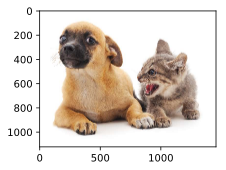

In [11]:
d2l.set_figsize()
print('input image shape:', img.shape)
d2l.plt.imshow(img);
print('output image shape:', out_img.shape)
d2l.plt.imshow(out_img);

在全卷积网络中，我们将转置卷积层初始化为双线性插值的上采样。
对于 1×1 卷积层，我们采用Xavier随机初始化。

In [12]:
# 反卷积
net.get_layer('tconv2d').set_weights([bilinear_kernel(num_classes, num_classes, 64)])
# 1x1 卷积初始化在模型设置时候已经设定好 
#   kernel_initializer='glorot_normal'

### 9.10.4 读取数据集

In [13]:
voc_dir = d2l.download_voc_pascal()
crop_size, batch_size, colormap2label = (320, 480), 32, np.zeros(256**3)
for i, cm in enumerate(d2l.VOC_COLORMAP):
    colormap2label[(cm[0] * 256 + cm[1]) * 256 + cm[2]] = i
    
voc_train = d2l.VOCSegDataset(True, crop_size, voc_dir, colormap2label)
voc_test = d2l.VOCSegDataset(False, crop_size, voc_dir, colormap2label)

read 1114 examples
read 1078 examples


### 9.10.5 训练模型 
因为我们选用的主干网络比原文大（ResNet50），所以epoch也要比原文多，效果会比原文刚好

In [14]:
def sparse_crossentropy_with_logits(y_true, y_pred):
    return K.mean(K.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True),
                  axis=-1)

In [15]:
net.compile(optimizer=keras.optimizers.Adam(),
            loss=keras.losses.sparse_categorical_crossentropy)

In [29]:
net.fit_generator(voc_train, epochs=30, workers=4, shuffle=True, validation_data=voc_test)

Epoch 1/30
34/34 [==============================] - 40s 1s/step - loss: 0.2171 - val_loss: 1.5073
Epoch 2/30
34/34 [==============================] - 39s 1s/step - loss: 0.1815 - val_loss: 1.7121
Epoch 3/30
34/34 [==============================] - 39s 1s/step - loss: 0.1575 - val_loss: 1.6361
Epoch 4/30
34/34 [==============================] - 38s 1s/step - loss: 0.1439 - val_loss: 1.3952
Epoch 5/30
34/34 [==============================] - 39s 1s/step - loss: 0.1395 - val_loss: 1.4974
Epoch 6/30
34/34 [==============================] - 39s 1s/step - loss: 0.1253 - val_loss: 1.3793
Epoch 7/30
34/34 [==============================] - 38s 1s/step - loss: 0.1318 - val_loss: 1.1938
Epoch 8/30
34/34 [==============================] - 39s 1s/step - loss: 0.1220 - val_loss: 1.3910
Epoch 9/30
34/34 [==============================] - 39s 1s/step - loss: 0.1193 - val_loss: 1.0405
Epoch 10/30
34/34 [==============================] - 39s 1s/step - loss: 0.1186 - val_loss: 0.8494
Epoch 11/30
34/34 [

### 9.10.6 预测像素类别
在预测时，我们需要将输入图像在各个通道做标准化，并转成卷积神经网络所需要的四维输入格式。

In [30]:
def predict(img):
    X = voc_test.normalize_image(img)
    X = np.expand_dims(X, axis=0)
    pred = net(tf.cast(X, tf.float32))
    pred_max = np.argmax(pred, axis=-1)
    return pred_max.reshape((pred_max.shape[1], pred_max.shape[2]))

In [31]:
def label2image(pred):
    colormap = np.array(d2l.VOC_COLORMAP, dtype='uint8')
    X = pred.astype('int32')
    return colormap[X, :]

pred: (320, 480) ; max = 1
pred: (320, 480) ; max = 19
pred: (320, 480) ; max = 9
pred: (320, 480) ; max = 19


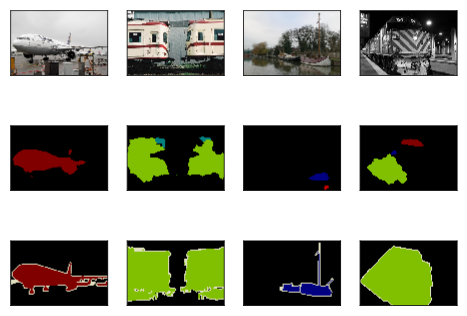

In [33]:
test_images, test_labels = d2l.read_voc_images('data/VOCdevkit/VOC2012', is_train=False)
n, imgs = 4, []
for i in range(n):
    X = test_images[i][0:320, 0:480]
    pred = predict(X)
    print('pred:', pred.shape, '; max =', np.max(pred))
    pred_labels = label2image(pred)
    imgs += [X, pred_labels, test_labels[i][0:320, 0:480]]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n);